# Taller #2 
## Simulador de vuelta e-kart parte 1
### Daniel Felipe Jaramillo Arenas, 201414139

La primera parte para el desarrollo del simulador es poder modelar como responde el carro bajo el modelo matemático que define tanto la aceleración como el frenado del kart. Las funciones son:

Para la aceleración se tiene:

$(M+M_r)a_x = \frac{T_e N_c \eta_t}{r} - R_x - D_A$ [Ecuación 1]  

Dónde:

$M=$ masa del Kart

$M_r=$ masa equivalente de los elementos rotativos

$a_x=$ aceleracion

$T_e=$ torque del motor

$N_c=$ relación de transmisión

$ \eta_t=$ eficiencia de la transmisión

$r=$ radio efectivo de la llanta

$R_x=f_rW $ es la fuerza de resistencia a la rodadura  

$D_A = \frac{1}{2}\rho A_f C_d v_x^2 $ es la fuerza de arrastre aerodinámico 

Y para el frenado se tiene:

$(M+M_r)a_x = \frac{T_f}{r} - R_x - D_A$ [Ecuación 2]  

Donde respecto a la ecuación 1 lo único que varía es $T_f$ que es igual a:

$T_f=$ torque de frenado

Partiendo de esto se generaron una serie de funciones que permiten calcular cada una de las partes que conforman los modelos. Estas funciones son:

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import pandas as pd
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


La función frodadura_const tiene como parámetros de entrada la velocidad y el peso del kart y esta retorna la fuerza de rodadura que es igual a $R_x=f_rW $ donde $f_r$ es función de la velocidad y W es una constante del kart:

In [2]:
def frodadura_const(vx,wx):# w= peso del kart, vx=velocidad del kart
    fr=0.01*(1+(vx/100.0))
    return wx*fr # (N)

La siguiente función es la farrastre que calcula la fuerza de arrastre:

In [3]:
# Fuerza de arrastre
def farrastre(vx,rhox,afx,cdx): 
    return (1.0/2.0)*rho*af*cd*(vx)**2 

Una de las variables del modelo de aceleración es el torque del motor. A partir de la caracterización de potencia del motor respecto a la velocidad angular del mismo es posible obtener el torque producido con la siguiente ecuación:

$P=(-0.00000004564538677*rpm^3)+(0.0001056995459*rpm^2)+(1.53209191*rpm)-1.895523696$ [2]

Donde el torque es igual a:

$T=\frac{P}{w}$

A continuación se observa la curva de torque respecto a rpm del motor:

Text(0.5,0,'n [rpm]')

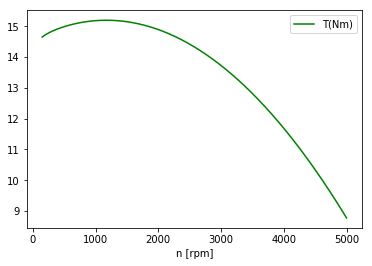

In [4]:
rpm=np.linspace(150,5000,2000)
P=(-0.00000004564538677*(rpm**3))+(0.0001056995459*(rpm**2))+(1.53209191*rpm)-1.895523696
T=P/(rpm*np.pi/30)
plt.plot(rpm,T, 'g', label='T(Nm)')
plt.legend(loc='best')
plt.xlabel('n [rpm]')

Es importante aclarar que para rpm entre 0 a 150 el torque se definió como constante y su valor es de 14,65 Nm y el torque está restringido por las rpm máximos del motor que son 5000. A partir de esto la función omega que tiene como parámetro la velocidad lineal, calcula la velocidad angular del motor y la función torqueMotor tiene como parámetro el resultado de la función omega y calcula el torque del motor:

In [5]:
def omega(vx,rx,Ncx):
    om=(vx/rx)*Ncx
    return (om)

In [6]:
def torqueMotor(omega):
    if ((omega*30)/np.pi)<=150:
        T=14.65
    if ((omega*30)/np.pi)>=5000:
        rpm=5000
        P=(-0.00000004564538677*(rpm**3))+(0.0001056995459*(rpm**2))+(1.53209191*rpm)-1.895523696
        T=P/(rpm*np.pi/30)
    else:
        rpm=(omega*30)/np.pi
        P=(-0.00000004564538677*(rpm**3))+(0.0001056995459*(rpm**2))+(1.53209191*rpm)-1.895523696
        T=P/(rpm*np.pi/30)
    return (T)

La siguiente función calcula la masa equivalente de los elementos rotativos:

In [7]:
def Masaequi(Iwx,Idx,Iex,Ncx,rx):
    Me=((Iwx+Idx)+(Iex*(Ncx**2)))/(rx**2)
    return (Me)

Tanto la función 1 como 2 son de orden 2 por lo que para poder utilizar el solucionador es necesario definir las funciones como:

$x'=v$

$v'=a$

Donde a es igual a:

1. Aceleración
$a=\frac{\frac{T_e N_c \eta_t}{r} - R_x - D_A}{(M+M_r)}$
2. Frenado
$a=\frac{\frac{T_f}{r} - R_x - D_A}{(M+M_r)}$

Con esto claro se tiene que:

#### Aceleración:

In [8]:
def funa(y,t,rhox,afx,cdx,rejex,Ncx,wx,Iwx,Idx,Iex,rx,efix):
    dist, vel=y
    #torqueMotor(omega(vel,rx,Ncx))
    acel=(((torqueMotor(omega(vel,rx,Ncx))*Ncx*efix)/rx)-frodadura_const(vel,wx)-farrastre(vel,rhox,afx,cdx))/((wx/9.81)+Masaequi(Iwx,Idx,Iex,Ncx,rx))
    dydt=[vel,acel]
    return dydt

#### Frenado:

In [9]:
def funf(y,t,rhox,afx,cdx,rejex,Ncx,wx,Iwx,Idx,Iex,rx,efix):
    dist, vel=y
    #torquedefrenos=cte=12 Nm
    acel=((-12/rx)-frodadura_const(vel,wx)-farrastre(vel,rhox,afx,cdx))/((wx/9.81)+Masaequi(Iwx,Idx,Iex,Ncx,rx))
    dydt=[vel,acel]
    return dydt

En las funciones funf y funa se tienen como parámetros todas las variables del kart. Esto permite realizar simulaciones modificando cualquiera de las variables. 

En este caso la única variable que se va a modificar es la relación de transmisión llamada Nc lo demás se considera constante y sus valores son:

In [10]:
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
reje=0.02 # Radio eje de las llantas (m)
efi=0.95 # Eficiencia de transmisión
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)
Ie=5.2E-3 # Inercia motor(kg m^2) 
mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
rin=0.0631 #radio interno del neumático (m)
rll=0.139 # Radio geométrico de las llantas en traseras (m)
r=0.98*rll # Radio efectivo llantas traseras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
Iw=2*illd+2*illt
meje=3.832 # Masa del eje (kg)
Id=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)


Todos los datos anteriores se obtuvieron de trabajos previos en el tema referenciados al final de este taller.[1][2]

A continuación se encuentra la función calAcel esta función calcula a partir de los datos de velocidad la aceleración en cada instante de tiempo:

In [11]:
def calAcel(Velx,rhox,afx,cdx,rejex,Ncx,wx,Iwx,Idx,Iex,rx,efix):
    numDatos=Velx.size
    acel=[]
    for i in range(0,numDatos):
        acel.append([(((torqueMotor(omega(Velx[i],rx,Ncx))*Ncx*efix)/rx)-frodadura_const(Velx[i],wx)-farrastre(Velx[i],rhox,afx,cdx))
        /((wx/9.81)+Masaequi(Iwx,Idx,Iex,Ncx,rx))])
    a=np.array(acel)
    return a    

### Modelo para evaluar el rendimiento del kart a diferentes relaciones de transmisión:

El modelo escrito a continuación primero define un arreglo con números de relaciones entre 3.45 y 1.54 dejando fijo el valor del piñón y variando el plato y con esto resuelve el modelo de aceleración para cada relación arrojando la siguiente información:

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


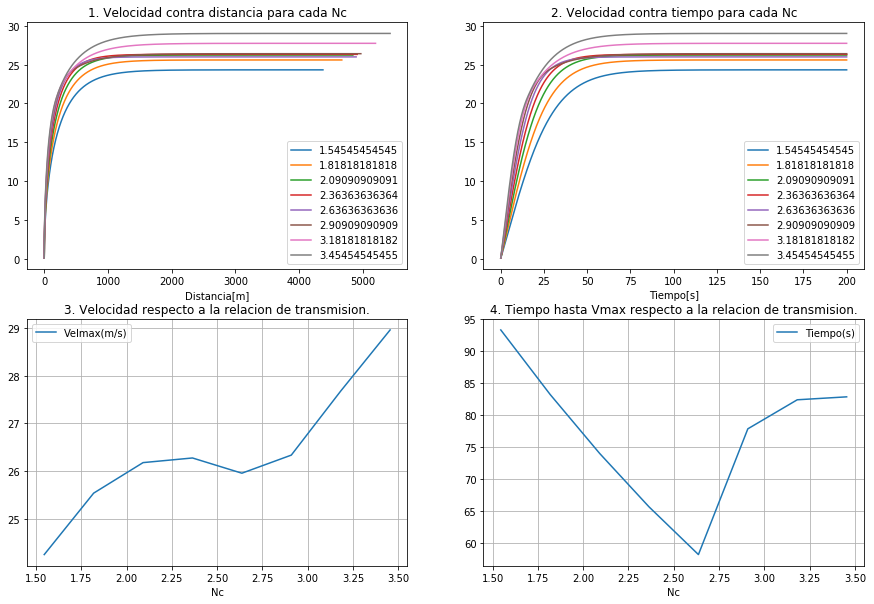

In [12]:
dp=11.0 # Dientes del piñon
dpl=np.array([17.0,20.0,23.0,26.0,29.0,32.0,35.0,38.0]) # Dientes del plato
Nc=dpl/dp
resul=[]
figure(figsize=(15,10))
for j in range(0,Nc.size):
    y0=[0.0,0.1]
    t0 = np.linspace(0,200,10000)
    sol0 = odeint(funa, y0, t0,args=(rho,af,cd,reje,Nc[j],w,Iw,Id,Ie,r,efi))
    acel=calAcel(sol0[:,1],rho,af,cd,reje,Nc[j],w,Iw,Id,Ie,r,efi)
    acelmax=np.amax(acel)
    plt.subplot(2,2,1)
    plt.plot(sol0[:,0],sol0[:,1], label=Nc[j])
    plt.legend(loc='best')
    plt.xlabel('Distancia[m]')
    plt.title('1. Velocidad contra distancia para cada Nc')
    plt.grid()
    plt.subplot(2,2,2)
    plt.plot(t0,sol0[:,1], label=Nc[j])
    plt.legend(loc='best')
    plt.xlabel('Tiempo[s]')
    plt.title('2. Velocidad contra tiempo para cada Nc')
    plt.grid()
    modelo=[]
    i=0
    while abs(sol0[i+1,1]-sol0[i,1])>=0.0001:
        modelo.append([t0[i],sol0[i,0],sol0[i,1]])
        i=i+1
        
    tVmax=modelo[-1][0]
    disVmax=modelo[-1][1]
    Vmax=modelo[-1][2]
    resul.append([Nc[j],tVmax,disVmax,Vmax,acelmax])
res=np.array(resul)
plt.subplot(2,2,3)
plt.plot(res[:,0],res[:,3], label='Velmax(m/s)')
plt.legend(loc='best')
plt.xlabel('Nc')
plt.title('3. Velocidad respecto a la relacion de transmision.')
plt.grid()

plt.subplot(2,2,4)
plt.plot(res[:,0],res[:,1], label='Tiempo(s)')
plt.legend(loc='best')
plt.xlabel('Nc')
plt.title('4. Tiempo hasta Vmax respecto a la relacion de transmision.')
plt.grid()

#figure()
#plt.plot(res[:,0],res[:,4], label='Aceleracion(m/s^2)')
#plt.legend(loc='best')
#plt.xlabel('Nc')
#plt.title('1. Aceleracion maxima respecto a la relacion de transmision.')
#plt.grid()

Como se puede observar en las gráficas con el cambio de las relaciones de transmisión las velocidades máximas, los tiempos en alcanzarlas y las distancias recorridas varían significativamente. La idea es poder encontrar una relación que permita alcanzar una velocidad máxima buena y que su aceleración también sea aceptable para que el tiempo que le tome en alcanzarla no sea muy grande. En la gráfica 4 se puede observar que la relación de Nc=2.64 es a la que en menor tiempo alcanza la velocidad máxima pero esta velocidad como se observa en la gráfica 3 no es ni la más alta y ni las más baja si no que se encuentra sobre la media. Para relaciones por debajo de 2 se puede ver que las velocidades se encuentran por debajo de la media y además los tiempos que se demoran en alcanzarlas son muy altos. Una relación que si valdría la pena evaluar al igual que la de 2.64 es la 2.91 ya que aunque el tiempo es mayor la velocidad máxima también es mayor por lo que podría dar un buen rendimiento. En la siguiente sección donde se realiza el modelo de aceleración hasta velocidad máxima y luego frenada se evaluaran tres relaciones:

1. Nc=3.55
2. Nc=2.64
3. Nc=2.91

### Modelo de aceleración hasta máxima velocidad y frenado

Una manera de observar las ventajas de una relación de transmisión es por medio de un modelo que permita calcular la distancia y el tiempo que le toma al kart acelerar hasta su velocidad máxima y luego frenar a fondo hasta que se detenga por completo. Partiendo de esto, el código que se encuentra a continuación permite modificar la relación de transmisión y solucionar el modelo matemático por medio de las funciones ya antes expuestas obteniendo con esto la velocidad máxima y a partir de esta solucionar el frenado. Con el modelo a continuación se obtienen cuatro diferentes graficas:

1. Velocidad respecto al tiempo solo con la aceleración

2. Aceleración respecto al tiempo solo con el modelo de aceleración.

3. Velocidad respecto al tiempo del modelo completo.

4. Distancia respecto al tiempo del modelo completo.

Y además se obtiene los datos de tiempo y distancia que le tomo al kart llegar a la velocidad máxima y frenar, y la velocidad máxima y el tiempo que le tomo llegar a la misma.

#### Caso 1: $Nc=\frac{39}{11}=3.55$ [1]

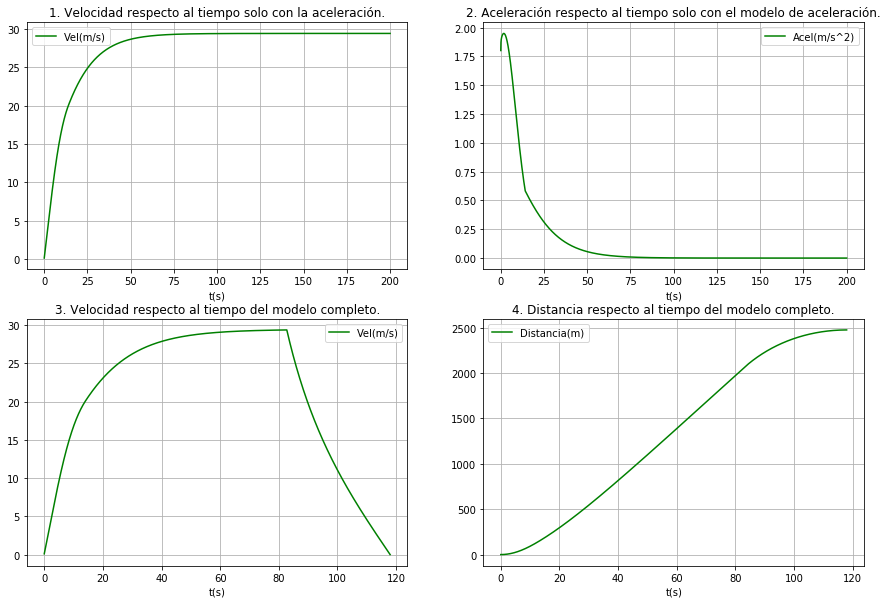

El tiempo que se demoro fue:  117.963508063 s
La distancia que recorrio fue:  2474.73014413 m
La velocidad maxima fue:  29.3652451656 m/s en 82.7282728273 s


In [13]:
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión

y0=[0.0,0.1]
t0 = np.linspace(0,200,10000)
sol0 = odeint(funa, y0, t0,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))
acel=calAcel(sol0[:,1],rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi)
modelo=[]
i=0
while sol0[i+1,1]-sol0[i,1]>0.0001:
    modelo.append([t0[i],sol0[i,0],sol0[i,1]])
    i=i+1
tVmax=modelo[-1][0]
disVmax=modelo[-1][1]
Vmax=modelo[-1][2]

y1=[0,Vmax]
t1 = np.linspace(0, 40, 1000)
sol1 = odeint(funf, y1, t1,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))

j=0
while sol1[j,1]>=0:
    modelo.append([tVmax+t1[j],disVmax+sol1[j,0],sol1[j,1]])
    j=j+1

mod=np.array(modelo)

figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(t0,sol0[:,1], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('1. Velocidad respecto al tiempo solo con la aceleración.')
plt.grid()
plt.subplot(2,2,2)
plt.plot(t0,acel, 'g', label='Acel(m/s^2)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('2. Aceleración respecto al tiempo solo con el modelo de aceleración.')
plt.grid()
plt.subplot(2,2,3)
plt.plot(mod[:,0],mod[:,2], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('3. Velocidad respecto al tiempo del modelo completo.')
plt.grid()
plt.subplot(2,2,4)
plt.plot(mod[:,0],mod[:,1], 'g', label='Distancia(m)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('4. Distancia respecto al tiempo del modelo completo.')
plt.grid()
plt.show()

print('El tiempo que se demoro fue: ',mod[-1,0],'s')
print('La distancia que recorrio fue: ',mod[-1,1],'m')
print('La velocidad maxima fue: ',Vmax,'m/s en',tVmax,'s')

Este es el caso propuesto por Córdoba como se puede observar la velocidad máxima que alcanza es de 29.36 m/s y la alcanza en 82.73 segundos. Para este caso y todos los demás el torque de freno se tomó a partir de los resultados obtenidos por Córdoba y se determinó como 12 Nm. Con esta relación el kart se demoró 117.96 segundos en realizar toda la acción y alcanzo a recorrer 2474.73 metros.

#### Caso 2: $Nc=\frac{29}{11}=2.64$

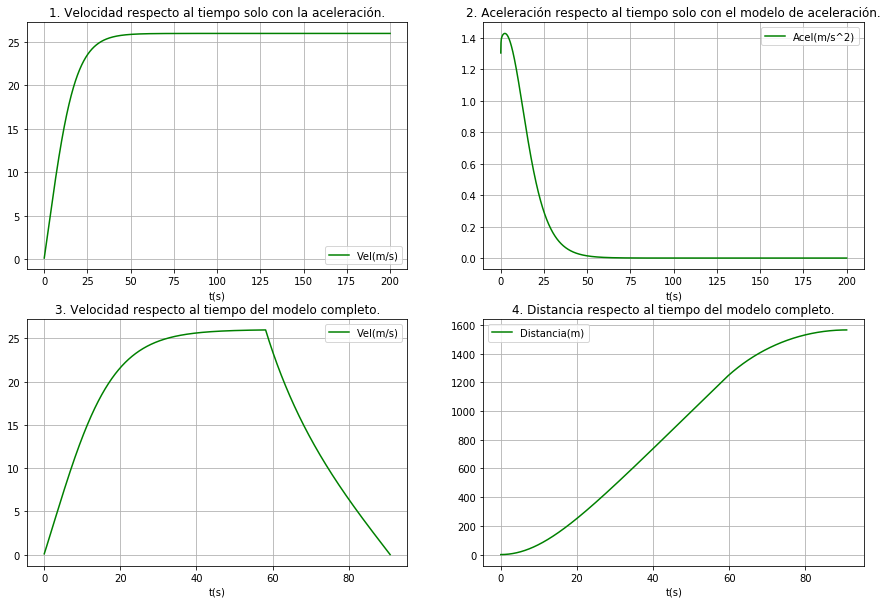

El tiempo que se demoro fue:  90.8785292944 s
La distancia que recorrio fue:  1565.5698825 m
La velocidad maxima fue:  25.9595843757 m/s en 58.1658165817 s


In [14]:
dp=11.0 # Dientes del piñon
dpl=29.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión

y0=[0.0,0.1]
t0 = np.linspace(0,200,10000)
sol0 = odeint(funa, y0, t0,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))
acel=calAcel(sol0[:,1],rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi)
modelo=[]
i=0
while sol0[i+1,1]-sol0[i,1]>0.0001:
    modelo.append([t0[i],sol0[i,0],sol0[i,1]])
    i=i+1
tVmax=modelo[-1][0]
disVmax=modelo[-1][1]
Vmax=modelo[-1][2]

y1=[0,Vmax]
t1 = np.linspace(0, 40, 1000)
sol1 = odeint(funf, y1, t1,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))

j=0
while sol1[j,1]>=0:
    modelo.append([tVmax+t1[j],disVmax+sol1[j,0],sol1[j,1]])
    j=j+1

mod=np.array(modelo)

figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(t0,sol0[:,1], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('1. Velocidad respecto al tiempo solo con la aceleración.')
plt.grid()
plt.subplot(2,2,2)
plt.plot(t0,acel, 'g', label='Acel(m/s^2)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('2. Aceleración respecto al tiempo solo con el modelo de aceleración.')
plt.grid()
plt.subplot(2,2,3)
plt.plot(mod[:,0],mod[:,2], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('3. Velocidad respecto al tiempo del modelo completo.')
plt.grid()
plt.subplot(2,2,4)
plt.plot(mod[:,0],mod[:,1], 'g', label='Distancia(m)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('4. Distancia respecto al tiempo del modelo completo.')
plt.grid()
plt.show()

print('El tiempo que se demoro fue: ',mod[-1,0],'s')
print('La distancia que recorrio fue: ',mod[-1,1],'m')
print('La velocidad maxima fue: ',Vmax,'m/s en',tVmax,'s')

En este segundo caso se observa que la velocidad máxima que alcanza es menor que en el caso 1 debido a la relación y se confirma los resultados obtenidos en la primera parte donde el tiempo hasta la velocidad máxima es de 58 segundos y su valor es de 25.96 m/s. La diferencia en las velocidades con respecto al caso 1 es de 3.4 m/s mientras que la diferencia del tiempo total del modelo es de 27.08 segundos. Esto lleva a concluir que esta relación podría llegar a dar un mejor rendimiento ya que aunque la velocidad va a ser menor no es significativamente más pequeña mientras que los tiempos si son significativamente más altos con la primera relación.

#### Caso 3: $Nc=\frac{32}{11}=2.91$

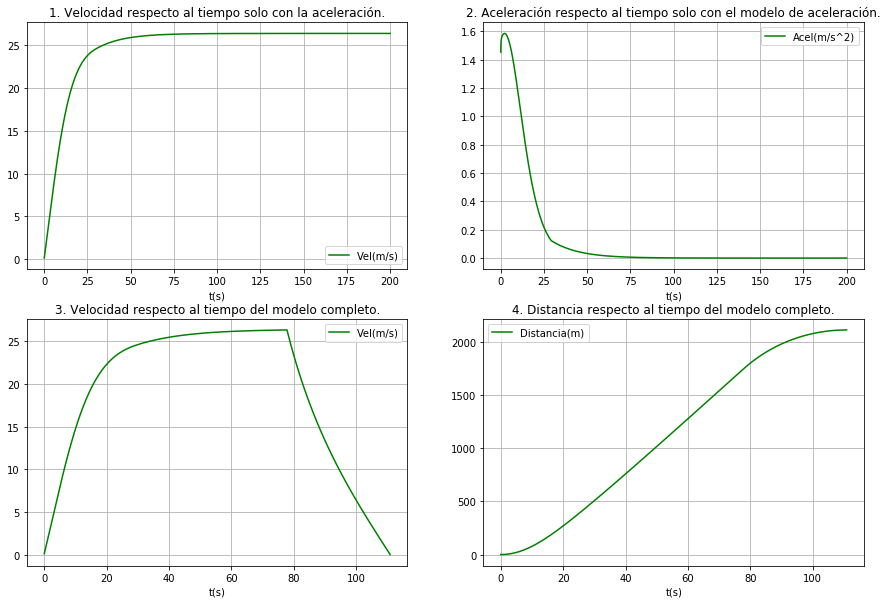

El tiempo que se demoro fue:  110.900855851 s
La distancia que recorrio fue:  2108.88909802 m
La velocidad maxima fue:  26.3373532819 m/s en 77.8277827783 s


In [15]:
dp=11.0 # Dientes del piñon
dpl=32.0 # Dientes del plato
Nc=dpl/dp # Relación de Transmisión

y0=[0.0,0.1]
t0 = np.linspace(0,200,10000)
sol0 = odeint(funa, y0, t0,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))
acel=calAcel(sol0[:,1],rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi)
modelo=[]
i=0
while sol0[i+1,1]-sol0[i,1]>0.0001:
    modelo.append([t0[i],sol0[i,0],sol0[i,1]])
    i=i+1
tVmax=modelo[-1][0]
disVmax=modelo[-1][1]
Vmax=modelo[-1][2]

y1=[0,Vmax]
t1 = np.linspace(0, 40, 1000)
sol1 = odeint(funf, y1, t1,args=(rho,af,cd,reje,Nc,w,Iw,Id,Ie,r,efi))

j=0
while sol1[j,1]>=0:
    modelo.append([tVmax+t1[j],disVmax+sol1[j,0],sol1[j,1]])
    j=j+1

mod=np.array(modelo)

figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(t0,sol0[:,1], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('1. Velocidad respecto al tiempo solo con la aceleración.')
plt.grid()
plt.subplot(2,2,2)
plt.plot(t0,acel, 'g', label='Acel(m/s^2)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('2. Aceleración respecto al tiempo solo con el modelo de aceleración.')
plt.grid()
plt.subplot(2,2,3)
plt.plot(mod[:,0],mod[:,2], 'g', label='Vel(m/s)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('3. Velocidad respecto al tiempo del modelo completo.')
plt.grid()
plt.subplot(2,2,4)
plt.plot(mod[:,0],mod[:,1], 'g', label='Distancia(m)')
plt.legend(loc='best')
plt.xlabel('t(s)')
plt.title('4. Distancia respecto al tiempo del modelo completo.')
plt.grid()
plt.show()

print('El tiempo que se demoro fue: ',mod[-1,0],'s')
print('La distancia que recorrio fue: ',mod[-1,1],'m')
print('La velocidad maxima fue: ',Vmax,'m/s en',tVmax,'s')

Con este último caso comparado con el caso 2 la diferencia de velocidades máximas es de 0.37 m/s y la diferencia de tiempos es de 20.02 segundos. Lo cual lleva a concluir que sigue siendo mejor utilizar la relación del caso 2, la ganancia de velocidad es muy baja y se requieren 20 segundos más para cumplir todo el modelo.

### Referencias

[1] 	M. Córdoba Parra, «Diseño de un tren de potencia para un kart eléctrico,» Universidad de los Andes, Bogota, 2016.

[2] 	D. G. Clavijo Pelayo, «Análisis, simulación e implementación de mejora del rendimiento para un kart eléctrico,» Universidad de los Andes, Bogota, 2017.

